## Week 5 - Semantic & Influence Networks 
Regina Catipon


In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [3]:
# Grabbing data
#news_data = pandas.read_csv("/Users/reginacatipon/Content-Analysis-2020/week-4/news_subset.csv")

news_data = pandas.read_csv("/home/rkcatipon/Content-Analysis-2020/week-4/news_subset.csv")


In [4]:
news_data.shape

(1874, 5)

In [5]:
# subset corpus is still too large, grabbing a subset
sample_data = news_data[:100]

In [6]:
for i in range(len(sample_data['Text'])):
    sample_data['Text'][i] = sample_data['Text'][i].replace('<', "" ).replace('h>','')
         

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# taking a peek at the cleaned data set, shouldn't have header tags anymore
sample_data['Text'][:3]

0    ##3527816  LiSA Blog 11/22/12 Ginkgo  Wow ? It...
1    ##3835511  Apparently was the case a few scene...
2    ##3836909  Seeking Excellent Advice About Cosm...
Name: Text, dtype: object

In [8]:
# tokenize and normalize
sample_data['tokenized_sents'] = sample_data['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
sample_data['normalized_sents'] = sample_data['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# This is news articles, it would be interesting to see if 
# there are words that co-occur in the same sentences:

def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [57]:
# wordConcurrrence as base for network
g = wordCooccurrence(sample_data['normalized_sents'].sum())

In [13]:
print("Total number of vertices:", len(g.nodes))
print("Total number of edges:", len(g.edges))

Total number of vertices: 7690
Total number of edges: 144355


In [14]:
#g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [15]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [16]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [19]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 7601
Number of edges: 144331
Average degree:  37.9768


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


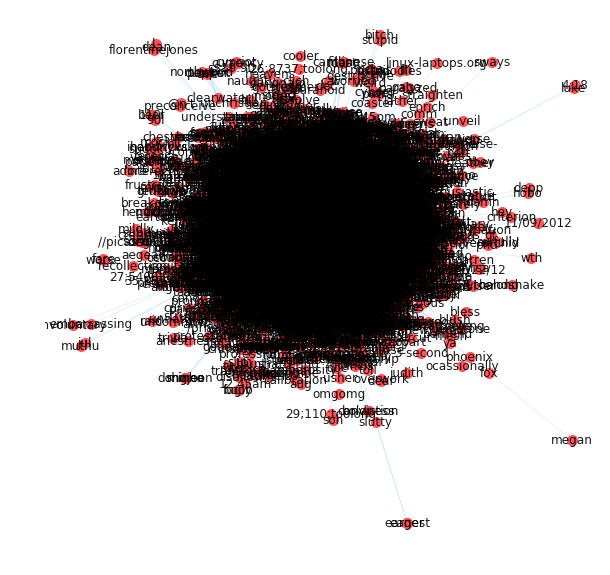

In [20]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

This doesn't tell me a whole lot about co-occurrence, except there are some words that are further out

## Two Mode network analysis

In [21]:
# tokenize and normalize text for two mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [22]:
# feature extraction and vectorization of tokenized text
import sklearn.feature_extraction
sampleVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
sampleVects_incidence = sampleVectorizer.fit_transform(sample_data['Text'])

In [23]:
# Checking the shape of the vectors. There should be 100 rows, because I limited the subset to 100
sampleVects_incidence.shape

(100, 7696)

<p style="color:blue">At this point, I need to induce the matrix onto a graph structure, but what does bipartite mean here?<p> 
<p style="color:blue">It means we are using document versus word frequency as a way to construct the bi-modal network.</p>

In [26]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((sampleVectorizer.get_feature_names()[i] for i in range(sampleVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(sampleVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, sampleVectorizer.get_feature_names()[w], {'weight' : sampleVects_incidence[d, w]}) for d, w in zip(*sampleVects_incidence.nonzero())))

In [27]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 7796
Number of edges: 20956
Average degree:   5.3761


In [28]:
# We already know that the nx.draw_networkx(g_2mode) will produce a spaghetti mess of a graph
# So either we filter (which we will down below) or we draw two unimodal networks.

In [29]:
# Function to create two networks
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [31]:
gDoc = contractNetwork(g_2mode, 'doc')

# I would be curious to see if this brings about any document to document connection
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4843
Average degree:  96.8600


In [33]:
# I guess there is a document to document connection because there will always be overlap in some word usage

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


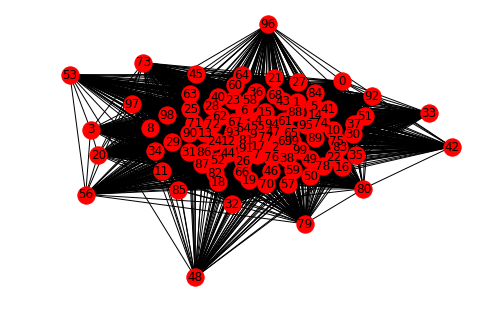

In [32]:
# edge weight distinguish model distance
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


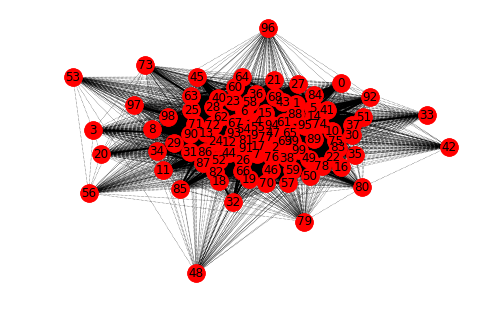

In [34]:
# Now with discernible thickness variation to demonstrate high and low weights

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [35]:
# pretty, but not very telling in terms of useful information to my research project.
# This does tell me that there are documents that are on the outside of the main, central cluster

In [38]:
# Let's look at 96 which is on the outside and compare it to 17 whih is near the center of the graph
print(len(sample_data.iloc[96]['Text']),"words:","\n",sample_data.iloc[96]['Text'].strip().replace('  ', '\n'))

263 words: 
 ##3527407
December 29 , 2005
In the middle of a massive computer meltdown and rebuild
So I have posted a few Christmas photos for everyone , but don't have much time for more emails and photos right yet . Hope to have more sooner than later . Posted by Nils


In [39]:
# ouch, I've been there Nils. I too have had computer meltdowns.
# let's see what node 17 is all about
print(len(sample_data.iloc[17]['Text']),"words:","\n",sample_data.iloc[17]['Text'].strip().replace('  ', '\n'))

9600 words: 
 ##3526608
Pages
Thursday , August 23 , 2012
You , I and Us : The politics of birth
Mr Lee Kuan Yew recently commented that Singapore would " fold up " if we did not raise the birth rate .
Mr Lee's remarks were made against the backdrop of an announcement that the Government would conduct another review of the Marriage and Procreation policy .
First off , whatever value judgments Singaporeans may make about his interpretation , no one can argue with the demographic facts .
We do have an abysmal birth rate , consequently we are dependent on population augmentation , and this does have undesirable and uncomfortable consequences ; but if we do not reverse the first and if we reject the second , we will face population decline within a generation . There should be no dispute here .
Predictably , however , Mr Lee's point of view provoked a volley of comments from Singaporeans . I have categorised the protestations into three buckets .
POINTING FINGERS
The first bucket contains 

In [40]:
# True to the instruction notebook, 17 is a node with a 
# large number of words in comparison, 9600 words to 263 words (node 96).

In [41]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 7696
Number of edges: 2939631
Average degree: 763.9374


In [42]:
# reduce number of words
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.2249602075906807

In [43]:
# Let's now filter the graph
g_filtered = wordCooccurrence(sample_data['normalized_sents'][:100].sum())

In [46]:
# filtering out weights below 15
g_filtered.remove_edges_from([(n1, n2) for n1, n2, d in g_filtered.edges(data = True) if d['weight'] <= 15])

In [49]:
# saving it to giant
giant = max(connected_component_subgraphs(g_filtered), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 3
Average degree:   2.0000


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


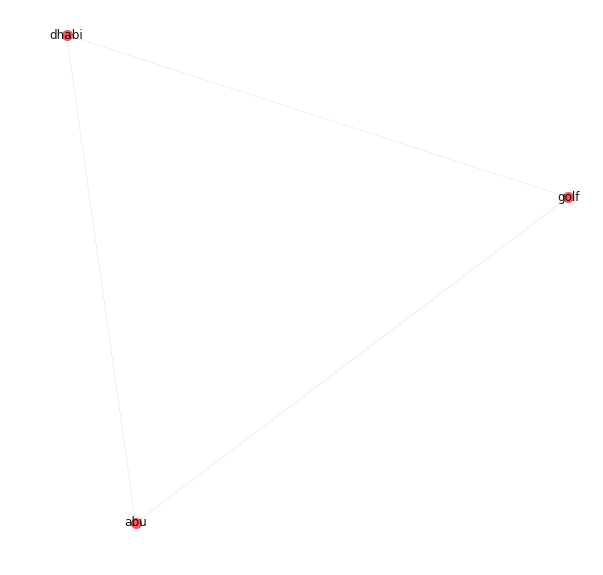

In [50]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Not exactly the most interesting connection, but it looks like the locaton of Abu Dhabi is semantically connected to golf?

In [53]:
# filtering out weights below 25, increasing from 15
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 50])

In [54]:
# I wonder what happens with the larger graph
giant_big = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant_big))

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


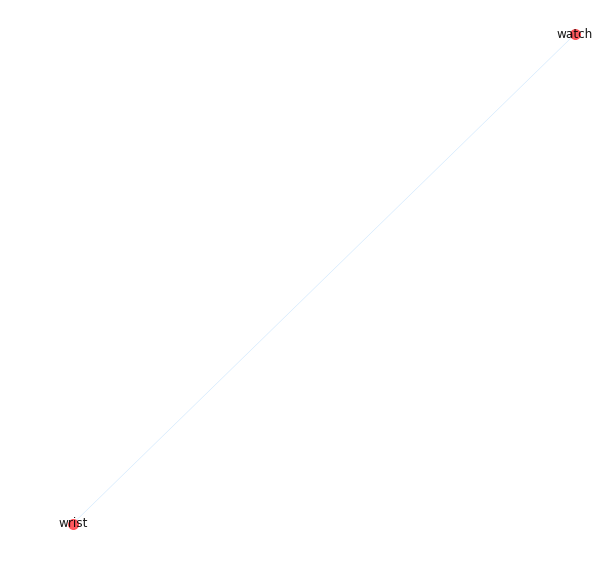

In [56]:
layout = nx.spring_layout(giant_big, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_big, ax = ax, pos = layout, labels = {n:n for n in giant_big.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [100]:
# setting g again
g = wordCooccurrence(sample_data['normalized_sents'].sum())

Power is the central node to "bank" and "reliance"- a literal power structure, Foucault would be chuffed. :)

In [101]:
# filtering out weights below 25, increasing from 15
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])

In [102]:
# I wonder what happens with the larger graph
dwarf = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 7690
Number of edges: 723
Average degree:   0.1880


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


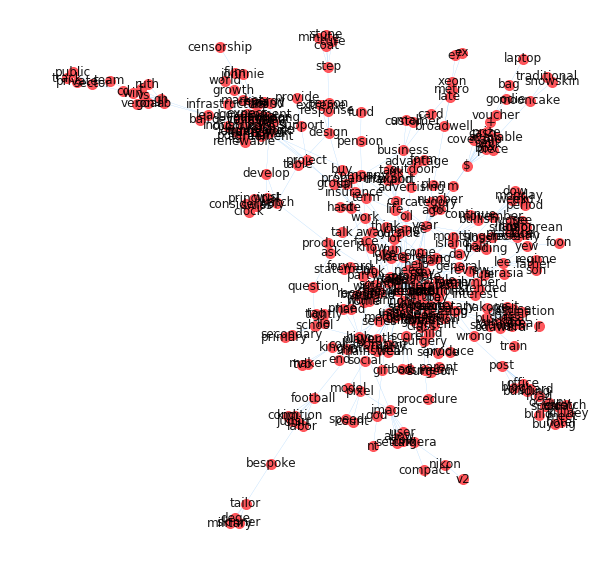

In [103]:
layout = nx.spring_layout(dwarf, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Aha! Finally, a bit more of an interesting graph. I noticed that "censorship", which relates to my research project.

In [104]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(dwarf))

In [109]:
c[:3][1:2]

[frozenset({'ab',
            'act',
            'agreement',
            'bali',
            'bank',
            'cd',
            'cdb',
            'censorship',
            'china',
            'coordinate',
            'development',
            'energy',
            'expect',
            'f',
            'film',
            'framework',
            'gh',
            'goal',
            'government',
            'growth',
            'guangdong',
            'india',
            'industry',
            'infrastructure',
            'johnnie',
            'lead',
            'lender',
            'limit',
            'market',
            'ming',
            'mingyang',
            'potential',
            'power',
            'private',
            'project',
            'provide',
            'public',
            'reliance',
            'renewable',
            'ruth',
            'sector',
            'support',
            'team',
            'track',
            'veron',
    

In [110]:
dwarf = nx.Graph(dwarf)

In [111]:
dwarf.remove_nodes_from([n for n in dwarf.nodes if len(set(dwarf.neighbors(n))) >= 2000]) 
dwarf.remove_nodes_from(list(nx.isolates(dwarf)))
print(nx.info(dwarf))

Name: 
Type: Graph
Number of nodes: 329
Number of edges: 584
Average degree:   3.5502


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


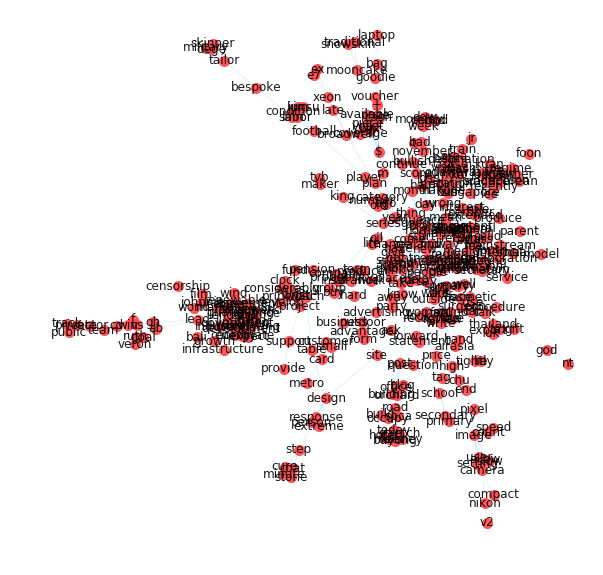

In [112]:
layout = nx.spring_layout(dwarf, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [114]:
print(', '.join(max(nx.clique.find_cliques(dwarf), key = lambda x: len(x))))

power, reliance, bank, yang, ming


In [116]:
powerNeighbors = dwarf.neighbors('power')
g_power = dwarf.subgraph(powerNeighbors)
print(nx.info(g_power))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 65
Average degree:   4.3333


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


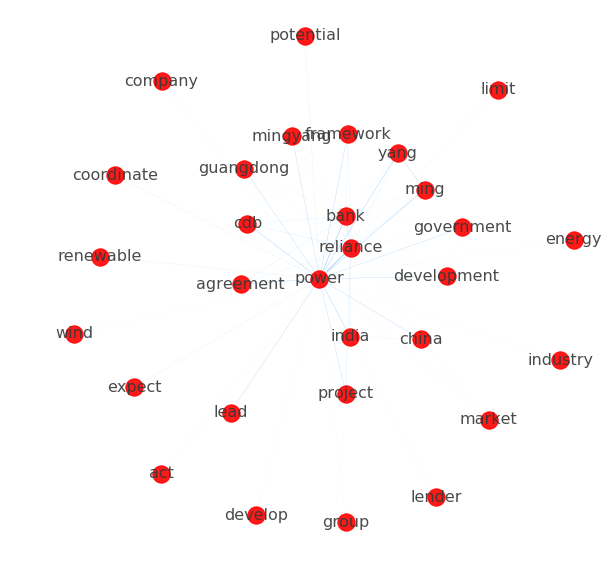

In [118]:
layout_amer = nx.spring_layout(g_power, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_power.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_power.edges(data = True)))
nx.draw(g_power, ax = ax, pos = layout_amer, labels = {n:n for n in g_power.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_power.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [125]:
# Power structure! When I tried to run a sub community graph, power did not have any secondary steps. 
# So let's look at a more common word


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [131]:

timeNeighbors = gWord.neighbors('time')
timeNeighborsPlus1 = set(timeNeighbors)
for n in timeNeighbors:
    timeNeighborsPlus1 |= set(dwarf.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)


g_time2 = giant.subgraph(timeNeighborsPlus1)
print(nx.info(g_time2))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 3
Average degree:   2.0000


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


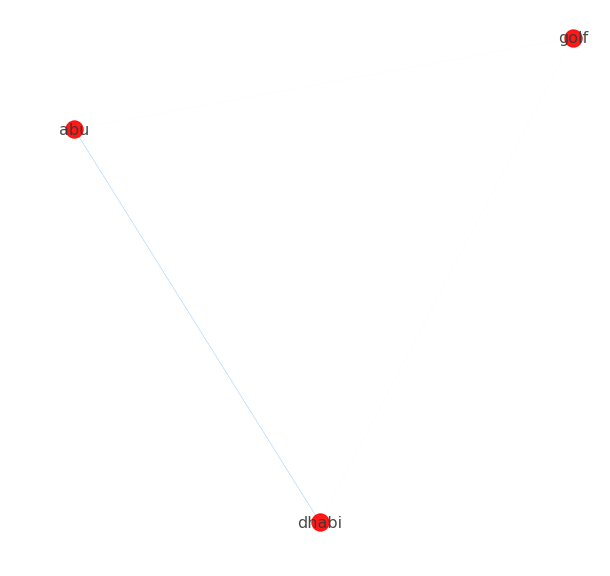

In [130]:
layout_amer = nx.spring_layout(g_time2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_time2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_time2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_time2.edges(data = True)))
nx.draw(g_time2, ax = ax, pos = layout_amer, labels = {n:n for n in g_time2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_time2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [138]:
dcentralities = nx.degree_centrality(dwarf)

In [139]:
if 'power' in dcentralities.keys():
    print(True)
else:
    print('not here')

True


In [140]:
dcentralities['power']

0.09451219512195122

In [141]:
max(dcentralities.items(), key = lambda x : x[1])

('power', 0.09451219512195122)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


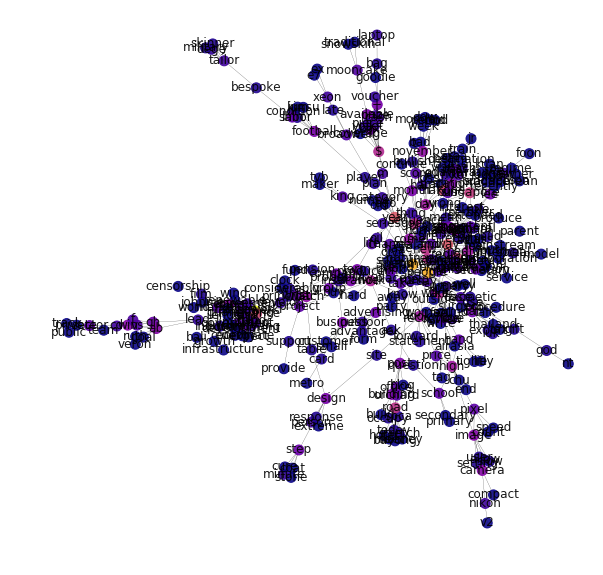

In [144]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in dwarf.nodes],
        cmap = plt.get_cmap('plasma')) 

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


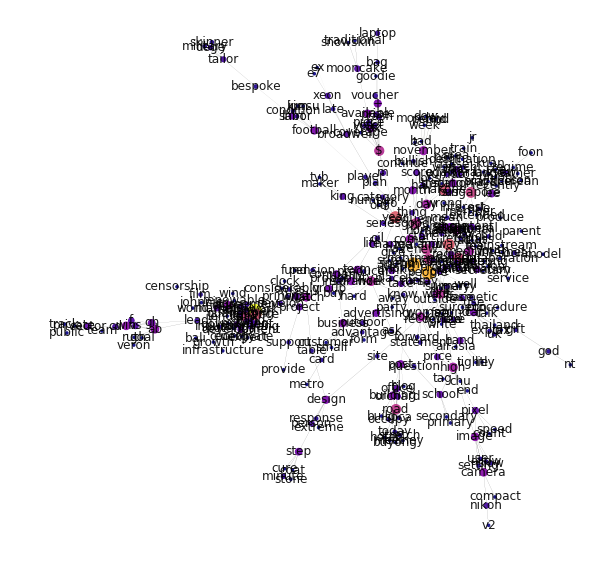

In [147]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in dwarf.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in dwarf.nodes],
        cmap = plt.get_cmap('plasma')) 

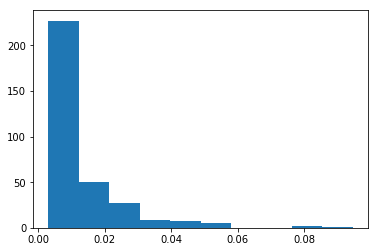

In [148]:
# degree centrality distribution for this news dataset
plt.hist(list(dcentralities.values()))
plt.show()

In [149]:
# Top ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('power', 0.09451219512195122),
 ('time', 0.07926829268292683),
 ('people', 0.07926829268292683),
 ('year', 0.054878048780487805),
 ('way', 0.054878048780487805),
 ('hakone', 0.05182926829268293),
 ('reliance', 0.04878048780487805),
 ('asean', 0.04878048780487805),
 ('bank', 0.04573170731707317),
 ('singapore', 0.04573170731707317)]

<span style="color:blue">We see that these words are time related... Common in journalism, seasonal</blue>



In [150]:
# Bottom ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('give', 0.003048780487804878),
 ('count', 0.003048780487804878),
 ('track', 0.003048780487804878),
 ('period', 0.003048780487804878),
 ('continue', 0.003048780487804878),
 ('parent', 0.003048780487804878),
 ('internet', 0.003048780487804878),
 ('wrong', 0.003048780487804878),
 ('recognize', 0.003048780487804878),
 ('goal', 0.003048780487804878)]

In [154]:
# Betweenness centrality distinguishes nodes that require the most 
# shortest pathways between all other nodes in the network.

bcentralities = nx.betweenness.betweenness_centrality(dwarf)

In [155]:
# checking the score for the previous top word
bcentralities['time']

0.2890773414252653

In [156]:
# sort top betweeness centralities
max(bcentralities.items(), key = lambda x : x[1])

('year', 0.3244106812786511)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


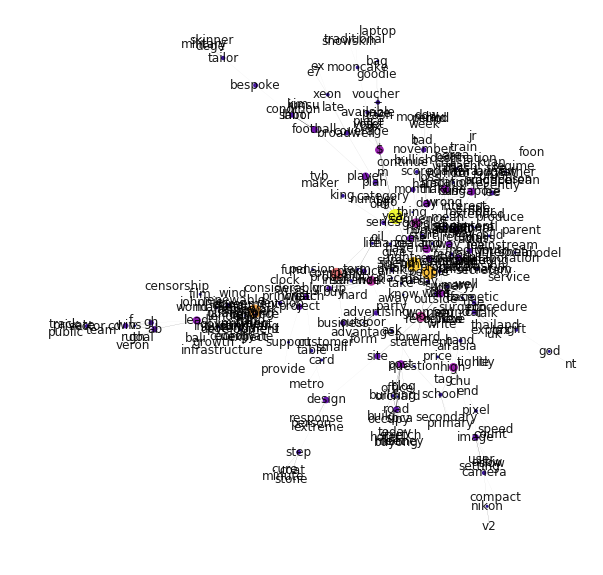

In [159]:
# We can color and size the nodes by betweenness centrality:

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in dwarf.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities[n] / maxC for n in dwarf.nodes],
        node_size = [bcentralities[n] / maxC * 200 for n in dwarf.nodes],
        cmap = plt.get_cmap('plasma')) 

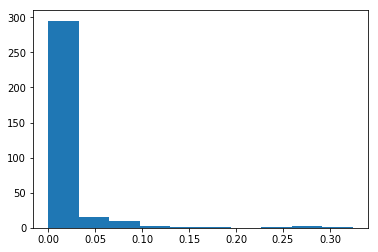

In [160]:
# Distribution plot of betweene
plt.hist(list(bcentralities.values()))
plt.show()

In [161]:
# Top ten when it comes to betweenness centrality
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('year', 0.3244106812786511),
 ('time', 0.2890773414252653),
 ('people', 0.27773921472561264),
 ('power', 0.2540910784225845),
 ('company', 0.19308977158607965),
 ('look', 0.13465724033804155),
 ('work', 0.12301533630344332),
 ('good', 0.11387255395275564),
 ('high', 0.09899552738974311),
 ('$', 0.0944282837323786)]

It looks like the top words are centered on XX


In [162]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('develop', 0.01898129649164557),
 ('china', 0.01827403595136869),
 ('camera', 0.01827403595136869),
 ('sector', 0.018236742000447528),
 ('surgery', 0.01821809502498695),
 ('available', 0.018199448049526366),
 ('tailor', 0.018190124561796077),
 ('use', 0.018180801074065788),
 ('think', 0.017743893043852495),
 ('start', 0.01638967163133644)]

In [163]:
#closeness centrialities
centralities = nx.closeness_centrality(dwarf)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


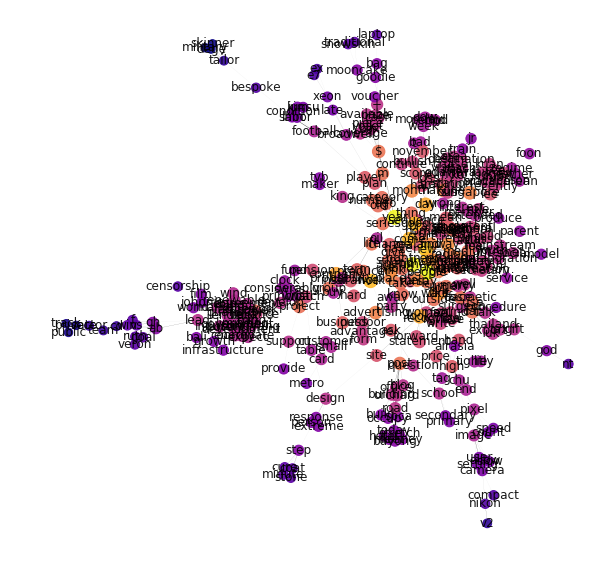

In [165]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in dwarf.edges(data = True)))
nx.draw(dwarf, ax = ax, pos = layout, labels = {n:n for n in dwarf.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in dwarf.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in dwarf.nodes],
        node_size = [centralities[n] / maxC * 200 for n in dwarf.nodes],
        cmap = plt.get_cmap('plasma')) 

In [166]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('people', 0.3109004739336493),
 ('year', 0.3082706766917293),
 ('time', 0.3076923076923077),
 ('new', 0.287467134092901),
 ('good', 0.2822719449225473),
 ('work', 0.28130360205831906),
 ('need', 0.28130360205831906),
 ('come', 0.2796248934356351),
 ('day', 0.27310574521232306),
 ('look', 0.2726517040731505)]

In [167]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('cd', 0.1243366186504928),
 ('team', 0.12428950359984843),
 ('tailor', 0.12019054598754123),
 ('v2', 0.12001463593121112),
 ('public', 0.11081081081081082),
 ('private', 0.11081081081081082),
 ('track', 0.11081081081081082),
 ('dege', 0.10740013097576949),
 ('skinner', 0.10736497545008183),
 ('military', 0.10736497545008183)]

In [170]:
# Eigen vector centrality failed on dataset

In [171]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [173]:
dwarf_filtered30 = filterWords(dwarf, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(dwarf_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 66
Average degree:   5.2800


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


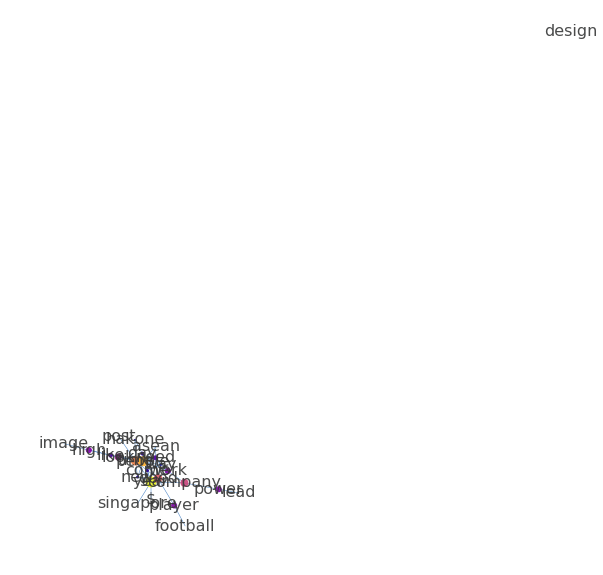

In [174]:
layout_giant_filtered30 = nx.spring_layout(dwarf_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(dwarf_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in dwarf_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in dwarf_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in dwarf_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [177]:
# We can also look at global statistics, like the density of a network, 
# defined as the number of actual edges divided by the total number of possible edges:

nx.density(dwarf)

0.010823634072206984

In [179]:
# average degree per node
np.mean([v for w,v in nx.degree(dwarf)])

3.5501519756838906

In [181]:
#average node distance
nx.diameter(dwarf)

14

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [182]:
# going back to spacy
import spacy
nlp = spacy.load('en')

In [183]:
# borrow parts of speech tagging for CoOccurrence
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [194]:
# Network nouns
gNN = posCooccurrence(sample_data['normalized_sents'].sum(), 'NN')

In [191]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 3236
Number of edges: 24594
Average degree:  15.2002


Way too many nodes

This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [195]:
# remove nodes
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 49
Number of edges: 550
Average degree:  22.4490


In [196]:
# filter edges
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 49
Number of edges: 101
Average degree:   4.1224


It went 3236 to 49 nodes, and from 24594 edges to 101.

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


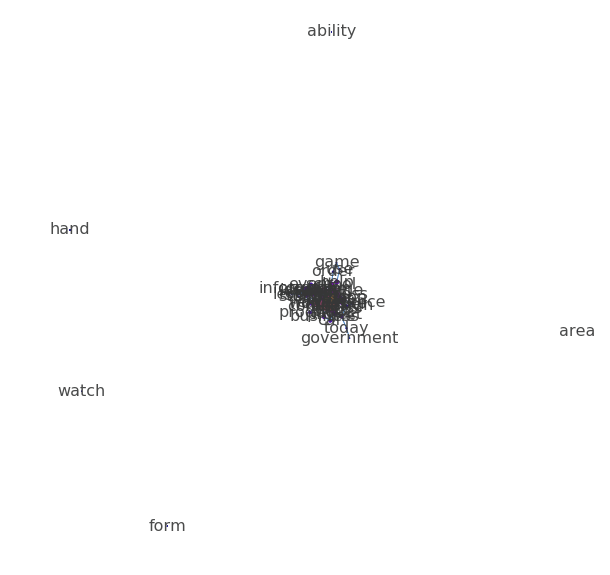

In [197]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

They seem to be very clustered with isolated nodes around the cluster.  

In [200]:
# vern-noun pairs
gNV = posCooccurrence(sample_data['normalized_sents'].sum(), 'NN', 'VB')

In [202]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [203]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 9
Average degree:   1.8000


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


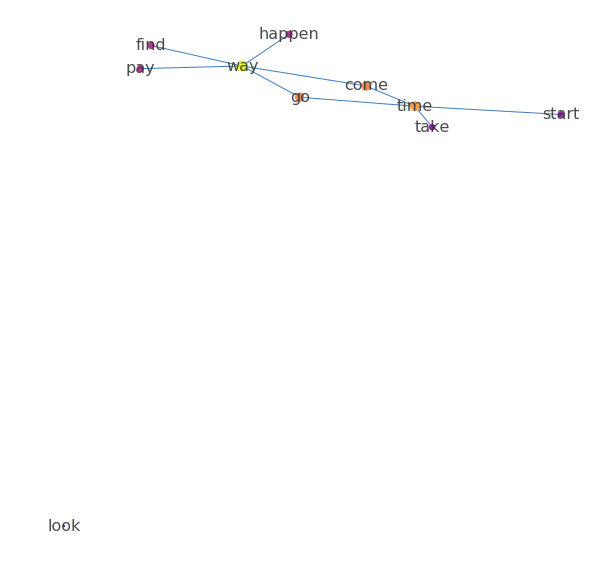

In [204]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

# Ego Network

In [206]:
g_i = gNV.subgraph(['way'] + list(gNV.neighbors('way')))

In [207]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 5
Average degree:   1.6667


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


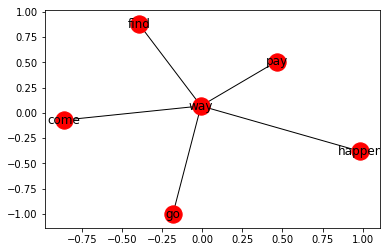

In [208]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [210]:
storyNeighbors = gNV.neighbors('way')
set(storyNeighbors)

{'come', 'find', 'go', 'happen', 'pay'}

In [212]:
# focusng on way, create sets from neighbors

storyNeighbors = set(gNV.neighbors('way'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [213]:
# Seems like a small network

gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 7
Average degree:   2.0000


In [214]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('way', 0.8333333333333333),
 ('time', 0.3333333333333333),
 ('come', 0.3333333333333333),
 ('go', 0.3333333333333333),
 ('pay', 0.16666666666666666),
 ('find', 0.16666666666666666),
 ('happen', 0.16666666666666666)]

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


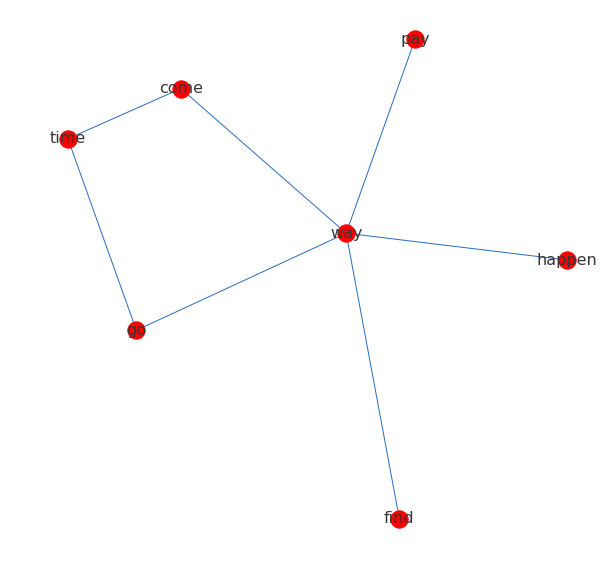

In [215]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [216]:
# Time has a triadic relationship with go and come. Noun verb


In [220]:
# noun adjectiev
gNJ = posCooccurrence(sample_data['normalized_sents'][:100].sum(), 'NN', 'JJ')
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 79
Average degree:   6.3200


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


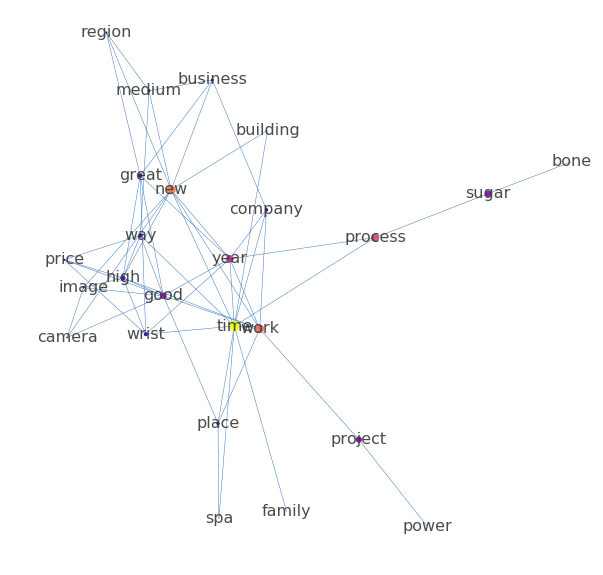

In [221]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?



I was working on a subset of the Davies Corpora that is a news subset for the assignment, because it is going to be a dataset where we compare our detected topics to. 


In [677]:

election_tweets = pd.read_excel("electionday_tweets.xlsx")

In [678]:
election_tweets.head()

,is_fake_news,fake_news_category,tweet_id,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count,user_favourites_count,tweet_source,geo_coordinates,num_hashtags,num_mentions,num_urls,num_media
0,False,NaN,264033382076407808,Thu Nov 01 15:57:18 +0000 2012,4698,@realDonaldTrump you are full of shit!,RalphGilles,True,763,26680,3079,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
1,False,NaN,265895586660757505,Tue Nov 06 19:17:02 +0000 2012,9646,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397,504,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,0,2,0,0
2,False,NaN,265895723445411841,Tue Nov 06 19:17:35 +0000 2012,1823,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1353,3355,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
3,False,NaN,265896172726661120,Tue Nov 06 19:19:22 +0000 2012,1168,@realDonaldTrump I am continually amazed and t...,MichaelWHill,False,1603,704,1479,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
4,False,NaN,266042962650226688,Wed Nov 07 05:02:39 +0000 2012,1979,Hey @realDonaldTrump You Mad Bro?,ThePresObama,False,135,70218,931,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,0,2,0,0


In [680]:
election_tweets['tokenized_text'] = election_tweets['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.word_tokenize(x)])
# normalized = lucem_illud_2020.normalizeTokens(tokenlist)


In [681]:
tokens = election_tweets['tokenized_text']


In [682]:
tokens[1][:]

[['@realDonaldTrump'], ['you'], ["'re"], ['fucking'], ['retarded']]

In [683]:
flat_list = []
for lis in tokens:
    
    flat_list.append([item for sublist in lis for item in sublist])
    

In [684]:
for tokens in flat_list:
    for word in tokens:
        word.lower()

In [685]:
#adjust dictionary so it loops correctly into tokenie text to find @mentions
'''
mentions = {}
for token in election_tweets['tokenized_text']:
    if "@" in token[0][0]:
        if token[0][0] not in mentions:
            mentions[token[0][0]] = 0
        if token[0][0] in mentions:
            mentions[token[0][0]] += 1
            

mentions = {}
for token in election_tweets['tokenized_text']: #index into each word
    for word in token:
        if "@" in word[0]: 
            if word[0] not in mentions:
                mentions[word[0]] = 0
            if word[0] in mentions:
                mentions[word[0]] += 1
'''

mentions = {}
for tokens in flat_list: #index into each word
    for word in tokens:
        if "@" in word: 
            if word not in mentions:
                mentions[word] = 0
            if word in mentions:
                mentions[word] += 1

      

In [686]:
# WHOO I found mentions, social interaction graph, here I come
len(mentions)


259

In [687]:
# I do not ant to filter out anything but I am interested in see what kinds of mentions I've collected
for mention in mentions:
        print(mention, mentions[mention])

@realDonaldTrump 479
@arcuate 1
@HillaryClinton 306
@Faith4Hillary 1
@VOTE_HILLARY 1
@VOTE_CLINTON 1
@ReadyForHillary 1
@johnnyhabit 1
@KEEMSTARx 1
@WikiLeaks 1
@hillaryclinton 3
@realdonaldtrump 15
@USARestoring 1
@TGowdySC 2
@megynkelly 1
@DonaldTrump 1
@AmyMek 1
@GOP 4
@RNC 1
.@realDonaldTrump 59
@EPN 1
@DanScavino 7
@Carolde 1
@CindyBlackwel12 1
@Realdonaldtrump 1
@SecretService 1
@KevJames91 1
@JebBush 1
@ananavarro 1
@secupp 1
@CNN 9
-@HillaryClinton 2
@WhiteGenocideTM 1
@themarcjacobs 1
@ChrisChristie 1
@ilduce2016 1
@MittRomney 1
@BarackObama 4
@MSNBC 2
@KatrinaPierson 1
@iamDaveK 1
@TheDonaldNews 1
.@BernieSanders 2
@JoeNBC 1
.@Ronc99 1
@bigop1 1
@oreillyfactor 1
@POTUS 14
@DiamondandSilk 2
@Socksguy 1
@AnthonyM1965 1
@Nelsonian210 1
@AnnCoulter 2
@RedRising11 1
🏽@realDonaldTrump 1
@Women4Trump 1
.@HillaryClinton 43
@RealDonaldTrump 5
@wikileaks 4
.@timkaine 2
@FieldofFight 2
@MGF_83 1
@DemConvention 1
@TimKaine 2
@CNBC 1
@NRA 2
.@Callisto1947 1
.@bfraser747 1
.@healthandcents

I'm noticing that there are a couple of mentions that are referring to the same person but have different spellings
I'm actually surprised that Twitter doesn't automatically do named entity resolution

In [591]:
mentions_network = nx.Graph()

In [592]:
for mention in mentions:
    if mentions[mention] > 2:
        mentions_network.add_node(mention, times_mentioned= mentions[mention], words=[])

In [629]:
len(mentions_network.nodes.data())

28

In [595]:
mentions_network.nodes['@realDonaldTrump']['times_mentioned']

479

In [596]:
len(election_tweets['tokenized_text'])

1327

In [597]:
election_tweets['tokenized_text'][1]

[['@realDonaldTrump'], ['you'], ["'re"], ['fucking'], ['retarded']]

In [598]:
flat_list[1][:]

['@realDonaldTrump', 'you', "'re", 'fucking', 'retarded']

In [701]:
for tokenlist in flat_list:
            
    for word in tokenlist: #index into each word
        if "@" in word:

            if word in mentions_network.nodes():
                j = i
                for word_ in tokens:
                    if "@" in word_:
                        #print(token)
                        if word_ != word and word_ in mentions_network.nodes():

                            if (word, word_) not in mentions_network.edges():
                                mentions_network.add_edge(word, word_, weight=0)
                            if (word, word_) in mentions_network.edges():
                                mentions_network.edges[(word, word_)]['weight'] += 1

                        break

                        j += 1
                    mentions_network.nodes[word]['words'].append(tokens[i:j])




/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


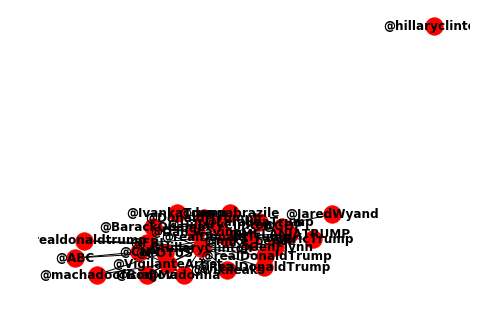

In [702]:
nx.draw(mentions_network, with_labels=True, font_weight='bold')

Huzzah!! We have a co-mentions network. Though it looks like when people mention @hillaryclinton, they do not mention others. We're also seeing multiple accounts that refer to the same group but have the same 

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


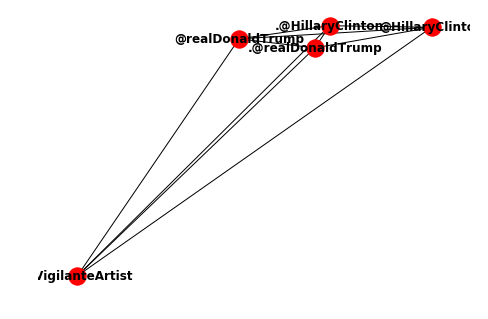

In [329]:
nx.draw(mentions_network, with_labels=True, font_weight='bold')

This is from an earlier iteration of the graph.

In [548]:
import seaborn as sns

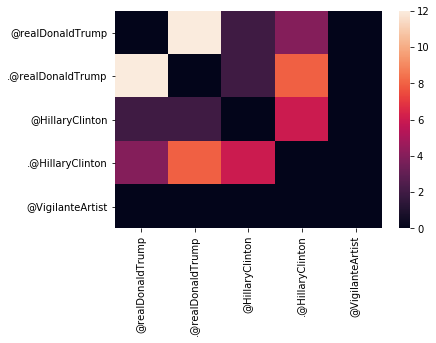

In [331]:
L = []
for node in mentions_network.nodes():
    l = []
    for node_ in mentions_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(mentions_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(mentions_network.nodes()), index = list(mentions_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [691]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(mentions_network))
c


[frozenset({'.@HillaryClinton',
            '.@realDonaldTrump',
            '@ABC',
            '@BarackObama',
            '@BonJovi',
            '@CNN',
            '@DanScavino',
            '@DonaldJTrumpJr',
            '@EricTrump',
            '@FBI',
            '@GOP',
            '@GenFlynn',
            '@HillaryClinton',
            '@IvankaTrump',
            '@JaredWyand',
            '@LaraLeaTrump',
            '@MELANIATRUMP',
            '@Madonna',
            '@POTUS',
            '@RealDonaldTrump',
            '@VigilanteArtist',
            '@donnabrazile',
            '@machadooficial',
            '@mike_pence',
            '@realDonaldTrump',
            '@realdonaldtrump',
            '@wikileaks'}),
 frozenset({'@hillaryclinton'})]

Because my network is already a little small, I am going to measure centrality on the community.

In [692]:
dcentralities = nx.degree_centrality(mentions_network)
dcentralities['@HillaryClinton'], dcentralities['@IvankaTrump']

(0.5185185185185185, 0.07407407407407407)